Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Yipei Zhang"
COLLABORATORS = ""

---

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\price}{{p}}
\newcommand{\ret}{{r}}
\newcommand{\tp}{{(t)}}
\newcommand{\aapl}{{\text{AAPL}}}
\newcommand{\ba}{{\text{BA}}}
\newcommand{\spy}{{\text{SPY}}}
$$

# Assignment: Using Machine Learning for Hedging

Welcome to the first assignment !

# Problem description

We will solve a Regression task that is very common in Finance
- Given the return of "the market", predict the return of a particular stock

That is
- Given the return of a proxy for "the market" at time $t$, predict the return of, e.g., Apple at time $t$.

As we will explain,
being able to predict the relationship between two financial instruments opens up possibilities
- Use one instrument to "hedge" or reduce the risk of holding the other
- Create strategies whose returns are independent of "the market"
    - Hopefully make a profit regardless of whether the market goes up or down

## Goal

You will create models of increasing complexity in order to explain the return of Apple (ticker $\aapl$)
- The first model will have a single feature: return of the market proxy, ticker $\spy$
- Subsequent models will add the return of other tickers as additional features

## Learning Objectives
- Learn how to solve a Regression task
- Become facile in the `sklearn` toolkit for Machine Learning

## How to report your answers
We will mix explanation of the topic with tasks that you must complete. 

Look for 
the string "**Question**" to find a task that you must perform.

Most of the tasks will require you to create some code at the location indicated by

>`# YOUR CODE HERE
raise NotImplementedError()`

- Replace `raise NotImplementedError()` with your own code

# Standard imports

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.HELPER()

# Get The data


The first step in our Recipe is Get the Data.

The data are the daily prices of a number of individual equities and equity indices.

The prices are arranged in a series in ascending date order (a timeseries).
- There are many `.csv` files for equity or index in the directory `DATA_DIR`

## API for students

We will define some utility routines to help you.

In this way, you can focus on the learning objectives rather than data manipulation.

This is not representative of the "real world"; you will need to complete data manipulation tasks in later assignments.

We provide a class `HELPER`
- Instantiated as 
>    `helper = helper.HELPER()`

With methods
- `getData`:
    - Get examples for a list of equity tickers and an index ticker.
    - Called as
    > `data = helper.getData( tickers, index_ticker, attrs)`
        - `tickers` is a list of tickers
        - `index` is the ticker of the index  
        - `attrs` is a list of data attributes
   

**Question:**
- Create code to
    - Get the adjusted close price of $\aapl$ and $\spy$ 
    - Assign the result to variable `data`

**Hint:**
- Use the `getData` method from the helper class
    - The list of tickers contains just the single ticker $\aapl$
    - The index ticker is $\spy$
    - The list of attributes is the single attribute `Adj Close`


In [4]:
ticker = ["AAPL"]
index_ticker = "SPY"
dateAttr = "Dt"
priceAttr = ["Adj Close"]

# YOUR CODE HERE
data = helper.getData(ticker, index_ticker, priceAttr)

# Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek at the data you retrieved

In [5]:
data.head()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2017-01-03,110.9539,213.8428
2017-01-04,110.8297,215.1149
2017-01-05,111.3933,214.9440
2017-01-06,112.6351,215.7131
2017-01-09,113.6668,215.0010


In [6]:
# Print the Start time and End time
print("Start time: ", data.index.min())
print("End time: ", data.index.max())

Start time:  2017-01-03
End time:  2019-10-31


Expected outputs should be similar to this:   
<img src="./images/data.png" width="300" height="200"/>


## Create DataFrame of price levels for the training examples

The training examples will be stored in a DataFrame.

- The DataFrame should have two columns: the price level for the ticker and for the index
- The minimum date in the DataFrame should be **the trading day before** `start_dt`
    - That is: the latest date for which there is data and which is less than `start_dt`
    - For example, if `start_dt` is a Monday, the "day before" would be Friday, not Sunday.
        - Similarly for the case where the day before `start_dt` is a holiday
- The maximum date in the DataFrame should be `end_dt`

The reason we are adding one day prior to `start_dt`
- We want to have returns (percent price changes) from `start_dt` onwards
- In order to compute a return for `start_dt`, we need the level from the prior day

**Question:**

- Complete the function `getRange()`
    - To return the subset of rows of our examples
    - Beginning on the **trading day before** date `start_dt`
    - Ending on date `end_dt`


In [7]:
start_dt = "2018-01-02"
end_dt = "2018-09-28"
train_data_price = None
# Set variable train_data_price to be a DataFrame with two columns
## AAPL_Adj_Close, SPY_Adj_Close
## with dates as the index
## Having minimum date equal to THE DAY BEFORE start_dt
## Having maximum date equal to end_dt

def getRange(df, start_dt, end_dt):
    '''
    Return the the subset of rows of DataFrame df
    restricted to dates between start_dt and end_dt
    
    Parameters
    ----------
    df: DataFrame
    - The data from which we will take a subset
    
    start_dt: String
    - Start date
    
    end_dt: String
    - End date
    '''
    # YOUR CODE HERE
    list_df = df.index.tolist() #convert the data into a list of strs
    start_row = list_df.index(start_dt)-1
    end_row = list_df.index(end_dt)     #Find the number of rows of the day before startdate and end date
    return df[start_row: end_row+1]
    
    
train_data_price = getRange(data, start_dt, end_dt)
print(train_data_price.head())

            AAPL_Adj_Close  SPY_Adj_Close
Dt                                       
2017-12-29        164.2589       258.2823
2018-01-02        167.1999       260.1310
2018-01-03        167.1708       261.7763
2018-01-04        167.9473       262.8796
2018-01-05        169.8594       264.6314


As you can see, each row has two attributes for one  date
- Price (adjusted close) of ticker $\aapl$
- Price (adjusted close) of the market proxy $\spy$

# Create test set

We just created a set of training examples as a subset of the rows of `data`.

We will do the same to create a set of test examples.

**Question:**

Set variable `test_data_price`
- To  the subset of rows of our examples
- Beginning on the **trading day before** date `test_start_dt`
- Ending on date `test_end_dt`

**Hint**
- Use `getRange` with different arguments for the dates

In [8]:
test_start_dt = '2018-10-01'
test_end_dt = '2018-12-31'

# YOUR CODE HERE
test_data_price = getRange(data, test_start_dt, test_end_dt)
print(test_data_price)


            AAPL_Adj_Close  SPY_Adj_Close
Dt                                       
2018-09-28        221.6252       285.0555
2018-10-01        223.1175       286.0458
2018-10-02        225.1006       285.8791
2018-10-03        227.8398       286.0359
2018-10-04        223.8342       283.8004
...                    ...            ...
2018-12-24        144.6565       231.1158
2018-12-26        154.8435       242.7929
2018-12-27        153.8386       244.6569
2018-12-28        153.9174       244.3412
2018-12-31        155.4050       246.4814

[64 rows x 2 columns]


# Prepare the data

In Finance, it is very typical to work with *relative changes* (e.g., percent price change)
rather than *absolute changes* (price change) or *levels* (prices).

Without going into too much detail
- Relative changes are more consistent over time than either absolute changes or levels
- The consistency can facilitate the use of data over a longer time period

For example, let's suppose that prices are given in units of USD (dollar)
- A price change of 1 USD is more likely for a stock with price level 100 than price level 10
    - A relative change of $1/100 = 1 %$ is more likely than a change of $1/10 = 10%$
    - So relative changes are less dependent on price level than either price changes or price levels
    
    
To compute the *return* (percent change in prices)
 for ticker $\aapl$ (Apple) on date $t$

$$
\begin{array}[lll]\\
\ret_\aapl^\tp = \frac{\price _\aapl^\tp}{\price _\aapl^{(t-1)}} -1 \\
\text{where} \\
\price_\aapl^\tp \text{ denotes the price of ticker } \aapl \text{ on date } t \\
\ret_\aapl^\tp \text{ denotes the return of ticker } \aapl \text{ on date } t
\end{array}
$$


# Transformations: transform the training data

Our first task is to transform the data from price levels (Adj Close)
to Percent Price Changes.

Moreover, the date range for the training data is specified to be in the range
from `start_dt` (start date) to `end_dt`, inclusive on both sides.

**Note**

We will need to apply **identical** transformations to both the training and test data examples.

In the cells that immediately follow, we will do this only for the **training data**

You will need to repeat these steps for the test data in a subsequent step.

You are well-advised to create subroutines or functions to accomplish these tasks !
- You will apply them first to transform training data
- You will apply them a second time to transform the test data

We will achieve this is several steps

## Create DataFrame of returns for training examples

Create a new DataFrame with percent price changes of the columns, rather than the levels

**Question:**
- Complete function `getReturns()` to set variable `train_data_ret` to be a DataFrame with the same columns
    - But where the prices have been replaced by day over day percent changes
    - The column names of `train_data_ret` should be the same as the original columns names
    - We give you code to rename the columns to reflect the changed meaning of the data in the next step

**Hint:**
- look up the Pandas `pct_change()` method    

In [9]:
train_data_ret = None

def getReturns(df, start_dt, end_dt):
    '''
    Return the day over day percent changes of adjusted price
    
    Parameters
    ----------
    df: DataFrame
    '''
    
    # YOUR CODE HERE
    data_index = df.index.tolist() #convert the data into a list of strs
    start_row = data_index.index(start_dt)-1
    end_row = data_index.index(end_dt) 
    train_dataset = df[start_row: end_row+1]
    return train_dataset.pct_change()

train_data_ret = getReturns(train_data_price,start_dt, end_dt)
train_data_ret.head()


,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2017-12-29,NaN,NaN
2018-01-02,0.017905,0.007158
2018-01-03,-0.000174,0.006325
2018-01-04,0.004645,0.004215
2018-01-05,0.011385,0.006664


Since the columns of `train_data_ret` are now returns, we will rename then for you.

Also, we will drop the earliest date
- There is now return for this date
- We included this row only so we could compute the return for the following trading date

In [10]:
## Rename the columns to indicate that they have been transformed from price (Adj_close) to Return
train_data_ret = helper.renamePriceToRet( train_data_ret )

## Drop the first date (the day before `start_dt`) since it has an undefined return
train_data_ret = train_data_ret[ start_dt:]
train_data_ret.head()

,AAPL_Ret,SPY_Ret
Dt,,
2018-01-02,0.017905,0.007158
2018-01-03,-0.000174,0.006325
2018-01-04,0.004645,0.004215
2018-01-05,0.011385,0.006664
2018-01-08,-0.003714,0.001829


  
Expected outputs should be similar to this:   
<img src="./images/train_data.png" width="250" height="150"/>

## Remove the target 

The only feature is the return of the market proxy $\spy$.

Predicting the target given the target as a feature would be cheating !

So we will create `X_train, y_train` from `train_data_ret`
- `X_train` has only features for the example
- `y_train` is the target for the example

In [43]:
tickerAttr = ticker + "_Ret"

X_train, y_train =  train_data_ret.drop(columns=[tickerAttr]), train_data_ret[[ tickerAttr ]]

In [44]:
# Since the above cell has some error and I can not fix it or delete it, I write a new cell here.
# It will cause error when running all cells, but I can not fix it because of the cell feature.
tickerAttr = ticker[0] + "_Ret"

X_train, y_train =  train_data_ret.drop(columns=[tickerAttr]), train_data_ret[[ tickerAttr ]]

KeyError: "['A_Ret'] not found in axis"

# Transformations: transform the test data

We have just performed some transformations of the training data.

**Remember**:

You need to perform *identical* transformations to the test data.

The test data will be returns from `test_start_dt` to `test_end_dt` inclusive.

We will apply identical transformations as we did to the training data, but with a different date range.


We obtained `X_train, y_train` via transformations to `train_data_price`.

We will now obtain `X_test, y_test` by identical transformations to `test_data_price`

**Question:**

Create the training data `X_test, y_test`
- Apply the same transformations to `test_data_price` as you did to `train_data_price`
- To create variable `test_data_ret`
- We will convert `test_data_ret` to `X_test, y_test` for you

**Hints**

Create `test_data_ret` in a manner analogous to the creation of `train_data_ret`
- Use `getReturns` to convert price levels to returns
- Use `helper.renamePriceToRet` to rename the columns to reflect the change in data from price to return
- Drop the first date from `test_data_ret` as it has an undefined return


In [13]:
test_data_price.head()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2018-09-28,221.6252,285.0555
2018-10-01,223.1175,286.0458
2018-10-02,225.1006,285.8791
2018-10-03,227.8398,286.0359
2018-10-04,223.8342,283.8004


In [14]:
test_data_ret = None
X_test = None
y_test = None

# YOUR CODE HERE
test_data_ret = getReturns(test_data_price, test_start_dt, test_end_dt)
test_data_ret = helper.renamePriceToRet( test_data_ret )
test_data_ret = test_data_ret[ test_start_dt:]
indexAttr = index_ticker + "_Ret"

X_test, y_test =  test_data_ret.drop(columns=[tickerAttr]), test_data_ret[[ tickerAttr ]]

print("test data length", test_data_ret.shape[0])
print("X test length", X_test.shape[0])
print("y test length", y_test.shape[0])
test_data_ret.head()

test data length 63
X test length 63
y test length 63


,AAPL_Ret,SPY_Ret
Dt,,
2018-10-01,0.006733,0.003474
2018-10-02,0.008888,-0.000583
2018-10-03,0.012169,0.000548
2018-10-04,-0.017581,-0.007815
2018-10-05,-0.016229,-0.005597


Expected outputs should be similar to this:   

test data length 63      
X test length 63      
y test length 63        

<img src="./images/test_data.png" width="250" height="150"/>



# Train a model (Regression)

Use Linear Regression to predict the return of a ticker from the return of the market proxy $\spy$.
For example, for ticker $\aapl$

$$
\ret_\aapl^\tp = \beta_0 + \beta_{\aapl, \spy} * \ret_\spy^\tp + \epsilon_{\aapl}^\tp
$$

Each example corresponds to one day (time $t$)
- has features
    - constant 1, corresponding to the intercept parameter
    - return of the market proxy $\spy$
       $$\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp
        \end{pmatrix}$$

- has target
    - return of the ticker
    $$\y^\tp = \ret_\aapl^\tp$$

 
You will use Linear Regression to solve for parameters $\beta_0$,  $\beta_{\aapl, \spy}$ 

- In the lectures we used the symbol $\Theta$ to denote the parameter vector; here we use $\mathbf{\beta}$
- In Finance the symbol $\beta$ is often used to denote the relationship between returns.
- Rather than explicitly creating a constant 1 feature
    - you may invoke the model object with the option including an intercept
    - if you do so, the feature vector you pass will be
   $$\x^\tp = \begin{pmatrix}
        \ret_\spy^\tp
        \end{pmatrix}$$  
    


- Use the entire training set
- Do not use cross-validation


**Question:**

Train your model to estimate the parameters beta_0 and beta_SPY   

- Complete the function `createModel()` to build your linear regression model. The detailed description is in the function below.
- Complete the function `regress()` to perform the regression and return two item: the intercept and coefficients. The detailed description is in the function below.
    - `beta_0` is the regression parameter for the constant; 
    - `beta_SPY` is the regression parameter for the return of SPY. 
    - We will test if the parameters of your regression are correct. We have initialized them to be 0. 

**Hints:**
- The input model of your function `regress()` should be the model you get from function `createModel()`
- Before you input your `X_train` and `y_train` into your `sklearn` model, you need to convert them from type `DataFrame` into type `ndarray`. 
    - You can convert a `DataFrame` into an `ndarray` with the `values` attribute, e.g., `X_train.values`

In [15]:
from sklearn import datasets, linear_model

beta_0 = 0    # The regression parameter for the constant
beta_SPY = 0  # The regression parameter for the return of SPY
ticker = "AAPL"

def createModel():
    '''
    Build your linear regression model using sklearn
    
    Returns
    -------
    An sklearn model object implementing Linear Regression
    '''
    # YOUR CODE HERE
    return linear_model.LinearRegression()

def regress(model, X, y):
    '''
    Do regression using returns of your ticker and index
    
    Parameters
    -----------
    model: model object implementing Linear Regression
        
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    Returns
    -------
    Tuple (beta_0, beta_SPY)
    where,
        beta_0: Scalar number 
        - Parameter for the constant

        beta_SPY: Scalar number
        - Parameter for the return of SPY
    

    '''
    # YOUR CODE HERE
    model.fit(X,y)
    intercept = model.intercept_[0]
    coefficient = model.coef_[0][0]
    return intercept, coefficient  

# Assign to answer variables
regr = createModel()

beta_0, beta_SPY = regress(regr, X_train, y_train)


print("{t:s}: beta_0={b0:3.3f}, beta_SPY={b1:3.3f}".format(t=ticker, b0=beta_0, b1=beta_SPY))

AAPL: beta_0=0.001, beta_SPY=1.071


Your expected outputs should be:
<table> 
    <tr> 
        <td>  
            beta_0
        </td>
        <td>
         0.001
        </td>
    </tr>
    <tr> 
        <td>
            beta_SPY
        </td>
        <td>
         1.071
        </td>
    </tr>

</table>

## Train the model using Cross validation

Since we only have one test set, we want to use 5-fold cross validation to assess model performance.

**Question:**
- Complete the function `compute_cross_val_avg()` to compute the average score of 5-fold cross validation
    - Set `cross_val_avg` as your average score of k-fold results
    - Set `k = 5` as the number of folds

**Hint:**  
- You can use the `cross_val_score` in `sklearn.model_selection`

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_avg = 0 # average score of cross validation
k = 5             # 5-fold cross validation

def compute_cross_val_avg(model, X, y, k):
    '''
    Compute the average score of k-fold cross validation
    
    Parameters
    -----------
    model: An sklearn model
    
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    k: Scalar number
    - k-fold cross validation
    
    Returns
    --------
    The average, across the k iterations, of the score
    '''
    # YOUR CODE HERE
    scores = cross_val_score(model, X, y, cv=k)
    return np.mean(scores)

    
cross_val_avg = compute_cross_val_avg(regr, X_train, y_train, 5)
print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

AAPL: Avg cross val score = 0.33


## Evaluate Loss (in sample RMSE) and Performance (Out of sample RMSE)

To see how well your model performs, we can check the in-sample loss and out-of-sample performance.   

**Question:**
- Complete the function `computeRMSE()` to compute the Root of Mean Square Error (RMSE)
    - Set `rmse_in_sample` to be in-sample loss
    - Set `rmse_out_sample` to be out-of-sample performance

In [17]:
from sklearn.metrics import mean_squared_error

rmse_in_sample = 0 # in sample loss
rmse_out_sample = 0 # out of sample performance

# Predicted  in-sample returns of AAPL using SPY index
aapl_predicted_in_sample = regr.predict(X_train)
# Predicted out-of-sample returns of AAPL using SPY index
aapl_predicted_out_sample = regr.predict(X_test)

def computeRMSE( target, predicted ):
    '''
    Calculate the RMSE
    
    Parameters
    ----------
    target: DataFrame
    - Real ticker returns
    
    predicted: ndarray
    - Predicted ticker returns
    
    Return
    ------
    Scalar number
    - The value of the RMSE
    '''
    # YOUR CODE HERE
    MSE = mean_squared_error(target, predicted)
    return np.sqrt(MSE)
    
rmse_in_sample = computeRMSE(y_train, aapl_predicted_in_sample)
rmse_out_sample = computeRMSE(y_test, aapl_predicted_out_sample)

print("In Sample Root Mean squared error: {:.3f}".format( rmse_in_sample ) )
print("Out of Sample Root Mean squared error: {:.3f}".format( rmse_out_sample ) )

In Sample Root Mean squared error: 0.011
Out of Sample Root Mean squared error: 0.015


## Hedged returns

Why is being able to predict the return of a ticker, given the return of another instrument (e.g., the market proxy) useful ?
- It **does not** allow us to predict the future
    - To predict $\ret_\aapl^\tp$, we require the same day return of the proxy $\ret_\spy$
- It **does** allow us to predict how much $\aapl$ will outperform the market proxy

Consider an investment that goes long (i.e, holds a positive quantity) of $\aapl$
- Since the relationship between returns is positive
    - You will likely make money if the market goes up
    - You will likely lose money if the market goes down
    
Consider instead a *hedged* investment
- Go long 1 USD of $\aapl$
- Go short (hold a negative quantity) $\beta_{\aapl,\spy}$ USD of the market proxy $\spy$

Your *hedged return* on this long/short portfolio will be
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$

As long as
$$
\ret_\aapl^\tp \gt \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
you will make a profit, regardless of whether the market proxy rises or falls !

That is: you make money as long as $\aapl$ *outperforms* the market proxy.


This hedged portfolio is interesting
- Because your returns are independent of the market
- The volatility of your returns is likely much lower than the volatility of the long-only investment
- There is a belief that it is difficult to predict the market $\ret_\spy$
- But you might be able to discover a ticker (e.g., $\aapl$) that will outpeform the market

This is a real world application of the Regression task in Finance.

## Compute the hedged return on the test data examples
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
for all dates $t$ in the **test set**.  


**Question:**  

Compute the hedged returns using your predicted series

- Complete the function `compute_hedged_series()` 
    - It should use your model results and the **test exmples** to compute the hedged returns. The detailed description is in the function below

**Hint**
- An `sklearn` model, once fitted, may have attributes `coef_` that give you access to the parameters



In [18]:
hedged_series = pd.DataFrame()

def compute_hedged_series(model, X, y):
    '''
    Compute the hedged series
    
    Parameters
    ----------
    model: An sklearn model
    
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    Return
    ------
    ndarray
    - Hedged return series 
    '''
    
    # YOUR CODE HERE
    AAPL_return = y
    beta = model.coef_
    Mrt_return = X.values 
    return AAPL_return - beta*Mrt_return

hedged_series = compute_hedged_series(regr, X_test, y_test)
print(hedged_series[:5])

            AAPL_Ret
Dt                  
2018-10-01  0.003012
2018-10-02  0.009512
2018-10-03  0.011581
2018-10-04 -0.009208
2018-10-05 -0.010233


# A model with more than one feature

Our simple model used a single feature (return of "the market") to make predictions.
- There are many more timeseries, stored as .CSV files, in the data directory

**Question**
- Construct a model with *more than one* feature by choosing from among these timeseries
- *Explain* why/how you chose the additional features
    - You may run multiple experiments if you choose
    - **Remember:** your notebook is a *movie*; we want to see your journey to your solution, not just the last step
- Report the average of the scores when using 5 fold cross-validation
- Report the in-sample and out of sample RMSE



In [19]:
# I choose to see the correlation of AAPL with all data within the directory.
# To see which stock has higher correlation with AAPL, and then implement it
# into my model.

### find all the stock in the Data directory

In [20]:
stock_list = os.listdir("Data")
stock_list.remove("AAPL.csv")
stock_list.remove("SPY.csv")
for i in range(len(stock_list)):
    stock_list[i] = stock_list[i].split(".")[0]

In [21]:
ticker = "AAPL"
index_ticker = "SPY"
dateAttr = "Dt"
priceAttr = ["Adj Close"]
tickers= [ticker] + stock_list #with new index_ticker XLP,XLK,and MSFT
# YOUR CODE HERE

new_data = helper.getData( tickers, index_ticker, priceAttr)
new_data.head()

,AAPL_Adj_Close,CSCO_Adj_Close,V_Adj_Close,ADBE_Adj_Close,XLE_Adj_Close,INTC_Adj_Close,XLF_Adj_Close,XLP_Adj_Close,MSFT_Adj_Close,ACN_Adj_Close,...,FB_Adj_Close,IBM_Adj_Close,XLY_Adj_Close,XLK_Adj_Close,XLI_Adj_Close,GOOG_Adj_Close,XLRE_Adj_Close,MA_Adj_Close,CRM_Adj_Close,SPY_Adj_Close
Dt,,,,,,,,,,,,,,,,,,,,,
2017-01-03,110.9539,27.8299,78.0492,103.48,69.7149,33.8738,22.3628,48.1496,59.4966,110.7381,...,116.86,146.9351,79.0179,46.9054,59.3227,786.14,28.2050,103.4719,70.54,213.8428
2017-01-04,110.8297,27.6644,78.6874,104.14,69.5685,33.6979,22.5435,48.1496,59.2304,111.0044,...,118.69,148.7543,80.0698,47.0689,59.6733,786.90,28.5616,104.4537,72.80,215.1149
2017-01-05,111.3933,27.7288,79.6102,105.91,69.3946,33.6424,22.3152,48.3073,59.2304,109.3403,...,120.67,148.2621,80.0119,47.1458,59.5027,794.02,28.7079,105.2604,72.79,214.9440
2017-01-06,112.6351,27.7839,80.7098,108.30,69.4586,33.7627,22.3913,48.3537,59.7438,110.5860,...,123.41,148.9916,80.4075,47.4919,59.8439,806.15,28.7079,106.0180,73.80,215.7131
2017-01-09,113.6668,27.7379,80.2582,108.57,68.4518,33.8830,22.2391,47.9640,59.5536,109.3499,...,124.90,147.3393,80.3400,47.4823,59.3795,806.65,28.5250,105.8114,73.96,215.0010


### It shows the correlation with all other indexes

In [22]:
# See all the correlation with AAPL
corr_list = new_data.corr()["AAPL_Adj_Close"]
corr_list

AAPL_Adj_Close    1.000000
CSCO_Adj_Close    0.775709
V_Adj_Close       0.873281
ADBE_Adj_Close    0.869277
XLE_Adj_Close     0.106807
INTC_Adj_Close    0.741465
XLF_Adj_Close     0.787756
XLP_Adj_Close     0.634670
MSFT_Adj_Close    0.872618
ACN_Adj_Close     0.884844
XLB_Adj_Close     0.657803
XLU_Adj_Close     0.715530
NVDA_Adj_Close    0.581038
XLV_Adj_Close     0.857343
FB_Adj_Close      0.608025
IBM_Adj_Close    -0.239701
XLY_Adj_Close     0.900569
XLK_Adj_Close     0.930162
XLI_Adj_Close     0.850510
GOOG_Adj_Close    0.880728
XLRE_Adj_Close    0.723696
MA_Adj_Close      0.862622
CRM_Adj_Close     0.830145
SPY_Adj_Close     0.921954
Name: AAPL_Adj_Close, dtype: float64

In [23]:
# Here are all the correlation with AAPL, abs(correlation) higher than 0.8 can be
# viewed as highly correlated. Therefore, I would use these stocks.
clean_list = corr_list[abs(corr_list)>0.8]
clean_list 


AAPL_Adj_Close    1.000000
V_Adj_Close       0.873281
ADBE_Adj_Close    0.869277
MSFT_Adj_Close    0.872618
ACN_Adj_Close     0.884844
XLV_Adj_Close     0.857343
XLY_Adj_Close     0.900569
XLK_Adj_Close     0.930162
XLI_Adj_Close     0.850510
GOOG_Adj_Close    0.880728
MA_Adj_Close      0.862622
CRM_Adj_Close     0.830145
SPY_Adj_Close     0.921954
Name: AAPL_Adj_Close, dtype: float64

In [24]:
clean_list = clean_list.drop("SPY_Adj_Close")
clean_list = clean_list.drop("AAPL_Adj_Close")

### Compute all scores for each selection

In [25]:
# I want to test all the combinations from my selected set, and test the R2
# for all selections and choose the highest one.
import itertools
all_combs = []
for i in range(len(clean_list)):
    iter_list = itertools.combinations(clean_list.index,i+1)
    for each in list(iter_list):
        all_combs.append(list(each) + ["SPY_Adj_Close"] + ["AAPL_Adj_Close"])

In [26]:
def total_function(test_tick):
    # write a function to do the whole process
    a = new_data[test_tick]
    new_X = a.drop(['AAPL_Adj_Close'], axis=1).pct_change().dropna()
    #new_X.head()
    new_y=a['AAPL_Adj_Close'].pct_change().dropna()
    #new_y.head()
    new_X_train = getRange(new_X, start_dt, end_dt)[ start_dt:]
    #new_X_train.head()
    new_y_train = getRange(new_y, start_dt, end_dt)[ start_dt:]
    #print(new_y_train.head())
    new_X_test = getRange(new_X, test_start_dt, test_end_dt)[ test_start_dt:]
    #new_X_test.head()
    new_y_test = getRange(new_y, test_start_dt, test_end_dt)[ test_start_dt:]
    #print(new_y_test.head())
    new_regr=linear_model.LinearRegression()
    new_regr.fit(new_X_train,new_y_train)
    new_cross_val_avg = np.mean(cross_val_score(new_regr, new_X_train, new_y_train, cv=5))
    new_aapl_predicted_in_sample = new_regr.predict(new_X_train)
    new_aapl_predicted_out_sample = new_regr.predict(new_X_test)
    new_rmse_in_sample = computeRMSE(new_y_train, new_aapl_predicted_in_sample)
    new_rmse_out_sample = computeRMSE(new_y_test, new_aapl_predicted_out_sample)
    return [new_cross_val_avg,new_aapl_predicted_in_sample,new_aapl_predicted_out_sample,new_rmse_in_sample,new_rmse_out_sample]

    
    
    
    

In [27]:
total_score = []
for i in all_combs:
    score = total_function(i)[0]
    total_score.append(score)

### Find out the best one selection

In [28]:
# This shows the index of the highest cross_val_score in the total list.
total_score = pd.Series(total_score)
max_index = total_score[total_score == total_score.max()]
print("Best Avg cross val score = {sc:3.2f}".format(sc=max_index.values[0]) )


Best Avg cross val score = 0.62


In [29]:
max_ticks = all_combs[max_index.index[0]]

In [30]:
# This is the dataframe which outputs the highest score.
max_features = new_data[max_ticks]
max_features

,V_Adj_Close,MSFT_Adj_Close,ACN_Adj_Close,XLV_Adj_Close,XLK_Adj_Close,GOOG_Adj_Close,CRM_Adj_Close,SPY_Adj_Close,AAPL_Adj_Close
Dt,,,,,,,,,
2017-01-03,78.0492,59.4966,110.7381,66.9012,46.9054,786.14,70.54,213.8428,110.9539
2017-01-04,78.6874,59.2304,111.0044,67.4280,47.0689,786.90,72.80,215.1149,110.8297
2017-01-05,79.6102,59.2304,109.3403,67.7729,47.1458,794.02,72.79,214.9440,111.3933
2017-01-06,80.7098,59.7438,110.5860,67.9645,47.4919,806.15,73.80,215.7131,112.6351
2017-01-09,80.2582,59.5536,109.3499,68.2519,47.4823,806.65,73.96,215.0010,113.6668
...,...,...,...,...,...,...,...,...,...
2019-10-25,177.8500,140.7300,183.0700,92.0600,82.9200,1265.13,150.49,301.6000,245.8419
2019-10-28,179.8400,144.1900,182.8700,93.0100,83.9700,1290.00,154.79,303.3000,248.3045
2019-10-29,177.6300,142.8300,184.8000,94.3300,83.2100,1262.62,155.09,303.2100,242.5618


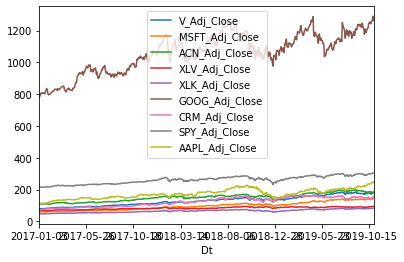

In [31]:
max_features.plot()

### Evaluate Loss (in sample RMSE) and Performance (Out of sample RMSE)

In [32]:
new_rmse_in_sample = total_function(max_ticks)[3]
new_rmse_out_sample = total_function(max_ticks)[4]
print("In Sample Root Mean squared error: {:.3f}".format( new_rmse_in_sample ) )
print("Out of Sample Root Mean squared error: {:.3f}".format( new_rmse_out_sample ) )

In Sample Root Mean squared error: 0.008
Out of Sample Root Mean squared error: 0.010


In [33]:
new_X = max_features.drop(['AAPL_Adj_Close'], axis=1).pct_change().dropna()
new_X.head()

,V_Adj_Close,MSFT_Adj_Close,ACN_Adj_Close,XLV_Adj_Close,XLK_Adj_Close,GOOG_Adj_Close,CRM_Adj_Close,SPY_Adj_Close
Dt,,,,,,,,
2017-01-04,0.008177,-0.004474,0.002405,0.007874,0.003486,0.000967,0.032039,0.005949
2017-01-05,0.011727,0.000000,-0.014991,0.005115,0.001634,0.009048,-0.000137,-0.000794
2017-01-06,0.013812,0.008668,0.011393,0.002827,0.007341,0.015277,0.013876,0.003578
2017-01-09,-0.005595,-0.003184,-0.011178,0.004229,-0.000202,0.000620,0.002168,-0.003301
2017-01-10,-0.005383,-0.000319,0.000521,0.003509,0.000202,-0.002306,0.000270,0.000000


In [34]:
new_y=max_features['AAPL_Adj_Close'].pct_change().dropna()
new_y.head()

Dt
2017-01-04   -0.001119
2017-01-05    0.005085
2017-01-06    0.011148
2017-01-09    0.009160
2017-01-10    0.001009
Name: AAPL_Adj_Close, dtype: float64

In [35]:
new_X_train = getRange(new_X, start_dt, end_dt)[ start_dt:]
print(new_X_train.head())

            V_Adj_Close  MSFT_Adj_Close  ACN_Adj_Close  XLV_Adj_Close  \
Dt                                                                      
2018-01-02     0.004297        0.004793       0.004900       0.011248   
2018-01-03     0.009955        0.004654       0.004615       0.009568   
2018-01-04     0.003719        0.008800       0.011841       0.001421   
2018-01-05     0.023949        0.012399       0.008249       0.008518   
2018-01-08     0.004038        0.001020       0.007992      -0.003636   

            XLK_Adj_Close  GOOG_Adj_Close  CRM_Adj_Close  SPY_Adj_Close  
Dt                                                                       
2018-01-02       0.012352        0.017775       0.021324       0.007158  
2018-01-03       0.008342        0.016413       0.008428       0.006325  
2018-01-04       0.005055        0.003621       0.013202       0.004215  
2018-01-05       0.010517        0.014571       0.013311       0.006664  
2018-01-08       0.003771        0.004273   

In [36]:
new_y_train = getRange(new_y, start_dt, end_dt)[ start_dt:]
print(new_y_train.head())

Dt
2018-01-02    0.017905
2018-01-03   -0.000174
2018-01-04    0.004645
2018-01-05    0.011385
2018-01-08   -0.003714
Name: AAPL_Adj_Close, dtype: float64


In [37]:
X_train_500=new_X[:500]
X_test_500=new_X[500:]
y_train_500=new_y[:500]
y_test_500=new_y[500:]

In [38]:
regr_500=linear_model.LinearRegression()
regr_500.fit(X_train_500,y_train_500)

LinearRegression()

In [39]:
score = cross_val_score(regr_500, X_train_500, y_train_500, cv=5).mean()
print("Avg cross val score = {sc:3.2f}".format(sc=score) )


Avg cross val score = 0.68


In [40]:
aapl_predicted_in_sample_500 = regr_500.predict(X_train_500)
aapl_predicted_out_sample_500 = regr_500.predict(X_test_500)
rmse_in_sample_500 = computeRMSE(y_train_500, aapl_predicted_in_sample_500)
rmse_out_sample_500 = computeRMSE(y_test_500,aapl_predicted_out_sample_500)
print("In Sample Root Mean squared error: {:.3f}".format( new_rmse_in_sample ) )
print("Out of Sample Root Mean squared error: {:.3f}".format( new_rmse_out_sample ) )


In Sample Root Mean squared error: 0.008
Out of Sample Root Mean squared error: 0.010


In [41]:
# This model has relatively good prediction, and it has higher prediction
# score when choosing different range of time. And the range of time also
# can be considered as feature for furture studies when prediction stock price.